In [1]:
try:
    get_ipython().run_line_magic("reset", "-f")
except NameError:
    is_notebook = False
    p = print
else:
    is_notebook = True
    p = display
    # p = print

import warnings

warnings.simplefilter("ignore")

from math import floor
import numpy as np
import pandas as pd

if is_notebook:
    import matplotlib.pyplot as plt
    import seaborn as sns
else:
    import asciichartpy

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss
from scipy.stats import norm
from scipy.optimize import minimize

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

input_dir = "march-machine-learning-mania-2025"

In [2]:
df_names = []
df_names_compact = []
df_names_detailed = []

for gender in ["M", "W"]:
    for part in ["RegularSeason", "NCAATourney", "SecondaryTourney"]:
        for result_type in ["Compact", "Detailed"]:
            if part == "SecondaryTourney" and result_type == "Detailed":
                continue
            df_name = f"{gender}{part}{result_type}Results"
            df_names.append(df_name)
            if result_type == "Compact":
                df_names_compact.append(df_name)
            else:
                df_names_detailed.append(df_name)
            print(df_name)
            path = f"../input/{input_dir}/{df_name}.csv"
            df = pd.read_csv(path)
            df["Part"] = part
            globals()[df_name] = df

season_min = WRegularSeasonDetailedResults["Season"].min()

for df_name in df_names:
    df = globals()[df_name]
    globals()[df_name] = df[df["Season"] >= season_min]

MRegularSeasonCompactResults
MRegularSeasonDetailedResults
MNCAATourneyCompactResults
MNCAATourneyDetailedResults
MSecondaryTourneyCompactResults
WRegularSeasonCompactResults
WRegularSeasonDetailedResults
WNCAATourneyCompactResults
WNCAATourneyDetailedResults
WSecondaryTourneyCompactResults


In [3]:
game_stats_1_2 = pd.DataFrame()

for df_name in df_names_detailed:
    game_stats_1_2 = pd.concat([game_stats_1_2, globals()[df_name]])

game_stats_1_2 = game_stats_1_2.reset_index(drop=True)
mask = game_stats_1_2["WTeamID"] < game_stats_1_2["LTeamID"]


def to_1_2(col_W_L):
    game_stats_1_2.loc[mask, f"{col_W_L}_1"] = game_stats_1_2[f"W{col_W_L}"]
    game_stats_1_2.loc[mask, f"{col_W_L}_2"] = game_stats_1_2[f"L{col_W_L}"]
    game_stats_1_2.loc[~mask, f"{col_W_L}_1"] = game_stats_1_2[f"L{col_W_L}"]
    game_stats_1_2.loc[~mask, f"{col_W_L}_2"] = game_stats_1_2[f"W{col_W_L}"]
    game_stats_1_2[f"{col_W_L}_1"] = game_stats_1_2[f"{col_W_L}_1"].astype(
        game_stats_1_2[f"W{col_W_L}"].dtype
    )
    game_stats_1_2[f"{col_W_L}_2"] = game_stats_1_2[f"{col_W_L}_2"].astype(
        game_stats_1_2[f"W{col_W_L}"].dtype
    )


game_stats_1_2["WLoc"] = game_stats_1_2["WLoc"].astype("category")
game_stats_1_2["LLoc"] = game_stats_1_2["WLoc"].cat.rename_categories(
    {"A": "H", "H": "A"}
)

for c in game_stats_1_2.columns:
    if c.startswith("W"):
        to_1_2(c[1:])

game_stats_1_2["Spread_1"] = game_stats_1_2["Score_1"] - game_stats_1_2["Score_2"]
game_stats_1_2["Spread_2"] = game_stats_1_2["Score_2"] - game_stats_1_2["Score_1"]
game_stats_1_2 = game_stats_1_2[[c for c in game_stats_1_2 if c[0] not in ("W", "L")]]
game_stats_1_2 = game_stats_1_2.drop(columns="NumOT")
game_stats_1_2.insert(2, "TeamID_1", game_stats_1_2.pop("TeamID_1"))
game_stats_1_2.insert(3, "TeamID_2", game_stats_1_2.pop("TeamID_2"))
game_stats_1_2 = game_stats_1_2.sort_values(
    ["Season", "DayNum", "TeamID_1", "TeamID_2"]
)
game_stats_1_2 = game_stats_1_2.reset_index(drop=True)
print(f"game_stats_1_2     {game_stats_1_2.shape[0]:,}")
p(game_stats_1_2)
print()

print(f"MRegularSeasonDetai{MRegularSeasonDetailedResults.shape[0]:>7,}")
print(f"WRegularSeasonDetai{WRegularSeasonDetailedResults.shape[0]:>7,}")
print(
    f"RegularSeasonDetail{MRegularSeasonDetailedResults.shape[0]+WRegularSeasonDetailedResults.shape[0]:>7,}"
)

reg_season = game_stats_1_2[game_stats_1_2["Part"] == "RegularSeason"]
print(f"reg_season         {reg_season.shape[0]:,}")

game_stats_1_o = reg_season.rename(
    columns={c: f"{c[:-2]}_o" for c in reg_season if c[-2:] == "_1"}
)
game_stats_1_o = game_stats_1_o.rename(
    columns={c: f"{c[:-2]}_d" for c in game_stats_1_o if c[-2:] == "_2"}
)
print(f"game_stats_1_o     {game_stats_1_o.shape[0]:,}")

game_stats_2_o = reg_season.rename(
    columns={c: f"{c[:-2]}_o" for c in reg_season if c[-2:] == "_2"}
)
game_stats_2_o = game_stats_2_o.rename(
    columns={c: f"{c[:-2]}_d" for c in game_stats_2_o if c[-2:] == "_1"}
)
print(f"game_stats_2_o     {game_stats_2_o.shape[0]:,}")
print(f"game_stats_1_o+2_o {game_stats_1_o.shape[0]+game_stats_2_o.shape[0]:,}\n")

game_stats_o_d = pd.concat([game_stats_1_o, game_stats_2_o])
game_stats_o_d = game_stats_o_d.drop(columns="Part")
game_stats_o_d.insert(2, "TeamID_o", game_stats_o_d.pop("TeamID_o"))
game_stats_o_d.insert(3, "TeamID_d", game_stats_o_d.pop("TeamID_d"))
game_stats_o_d = game_stats_o_d.sort_values(
    ["Season", "DayNum", "TeamID_o", "TeamID_d"]
)
game_stats_o_d = game_stats_o_d.reset_index(drop=True)
print(f"game_stats_o_d     {game_stats_o_d.shape[0]:,}")
p(game_stats_o_d)
print()

game_stats_1_2     166,128


,Season,DayNum,TeamID_1,TeamID_2,Part,Score_1,Score_2,FGM_1,FGM_2,FGA_1,FGA_2,FGM3_1,FGM3_2,FGA3_1,FGA3_2,FTM_1,FTM_2,FTA_1,FTA_2,OR_1,OR_2,DR_1,DR_2,Ast_1,Ast_2,TO_1,TO_2,Stl_1,Stl_2,Blk_1,Blk_2,PF_1,PF_2,Spread_1,Spread_2
0,2010,7,1107,1393,RegularSeason,43,75,15,29,55,60,5,2,28,17,8,15,14,31,12,14,27,32,10,21,32,21,12,21,4,6,27,16,-32,32
1,2010,7,1108,1326,RegularSeason,60,100,21,39,61,73,7,14,17,33,11,8,20,12,11,13,24,34,7,29,13,6,4,8,5,6,16,19,-40,40
2,2010,7,1143,1293,RegularSeason,75,70,24,26,52,52,5,8,12,21,22,10,32,15,13,11,19,20,15,11,12,17,8,7,1,3,14,24,5,-5
3,2010,7,1198,1314,RegularSeason,72,88,25,34,68,61,8,4,23,13,14,16,17,19,13,12,16,32,15,23,20,26,14,10,2,8,18,19,-16,16
4,2010,9,1143,1178,RegularSeason,95,61,29,20,61,57,7,4,17,18,30,17,35,27,15,14,30,18,11,14,10,15,5,4,3,2,20,21,34,-34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166123,2025,106,3150,3378,RegularSeason,52,70,18,25,58,59,5,4,17,17,11,16,14,18,7,8,24,30,5,15,15,12,8,9,2,3,15,16,-18,18
166124,2025,106,3194,3349,RegularSeason,39,72,10,30,55,63,3,10,17,24,16,2,23,4,4,5,25,39,5,21,10,10,4,6,3,5,9,14,-33,33
166125,2025,106,3242,3416,RegularSeason,63,58,17,23,46,63,4,7,17,26,25,5,28,11,5,15,26,21,9,11,12,12,4,4,5,2,16,21,5,-5
166126,2025,106,3329,3428,RegularSeason,68,64,23,25,63,58,6,5,23,23,16,9,18,16,18,8,25,18,9,16,17,11,6,8,3,6,21,20,4,-4



MRegularSeasonDetai 83,674
WRegularSeasonDetai 80,626
RegularSeasonDetail164,300
reg_season         164,300
game_stats_1_o     164,300
game_stats_2_o     164,300
game_stats_1_o+2_o 328,600

game_stats_o_d     328,600


,Season,DayNum,TeamID_o,TeamID_d,Score_o,Score_d,FGM_o,FGM_d,FGA_o,FGA_d,FGM3_o,FGM3_d,FGA3_o,FGA3_d,FTM_o,FTM_d,FTA_o,FTA_d,OR_o,OR_d,DR_o,DR_d,Ast_o,Ast_d,TO_o,TO_d,Stl_o,Stl_d,Blk_o,Blk_d,PF_o,PF_d,Spread_o,Spread_d
0,2010,7,1107,1393,43,75,15,29,55,60,5,2,28,17,8,15,14,31,12,14,27,32,10,21,32,21,12,21,4,6,27,16,-32,32
1,2010,7,1108,1326,60,100,21,39,61,73,7,14,17,33,11,8,20,12,11,13,24,34,7,29,13,6,4,8,5,6,16,19,-40,40
2,2010,7,1143,1293,75,70,24,26,52,52,5,8,12,21,22,10,32,15,13,11,19,20,15,11,12,17,8,7,1,3,14,24,5,-5
3,2010,7,1198,1314,72,88,25,34,68,61,8,4,23,13,14,16,17,19,13,12,16,32,15,23,20,26,14,10,2,8,18,19,-16,16
4,2010,7,1293,1143,70,75,26,24,52,52,8,5,21,12,10,22,15,32,11,13,20,19,11,15,17,12,7,8,3,1,24,14,-5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328595,2025,106,3398,3404,52,73,20,24,60,57,3,5,19,14,9,20,15,28,12,13,22,24,8,15,20,19,12,10,2,6,20,13,-21,21
328596,2025,106,3404,3398,73,52,24,20,57,60,5,3,14,19,20,9,28,15,13,12,24,22,15,8,19,20,10,12,6,2,13,20,21,-21
328597,2025,106,3416,3242,58,63,23,17,63,46,7,4,26,17,5,25,11,28,15,5,21,26,11,9,12,12,4,4,2,5,21,16,-5,5
328598,2025,106,3428,3329,64,68,25,23,58,63,5,6,23,23,9,16,16,18,8,18,18,25,16,9,11,17,8,6,6,3,20,21,-4,4


In [4]:
# Look at the distribution of games per team
games_per_team = game_stats_o_d.rename(columns={"TeamID_o": "TeamID"}).drop(
    columns="TeamID_d"
)
games_per_team_count = games_per_team.groupby(["Season", "TeamID"]).size()

# Count how many team-seasons have each number of games
games_count_distribution = games_per_team_count.value_counts().sort_index()
print("Distribution of games per team-season:")
print(games_count_distribution)

# Look at specific examples of teams with very few games
teams_with_few_games = games_per_team_count[games_per_team_count <= 10].reset_index()
print("\nSample of teams with 10 or fewer games:")
print(teams_with_few_games.head(10))

# Check if there's a pattern by season
few_games_by_season = teams_with_few_games.groupby("Season").size()
print("\nNumber of teams with few games by season:")
print(few_games_by_season)

Distribution of games per team-season:
2        1
4        3
5        2
6        2
8        2
9        3
10       3
11       2
12       3
13       7
14      12
15      25
16      17
17      20
18      44
19      47
20      73
21      92
22     138
23     179
24     264
25     335
26     425
27     591
28     977
29    1498
30    2076
31    1971
32    1427
33     702
34     272
35      26
36       2
Name: count, dtype: int64

Sample of teams with 10 or fewer games:
   Season  TeamID   0
0    2021    1110  10
1    2021    1152   9
2    2021    1224   4
3    2021    1263   9
4    2021    3137  10
5    2021    3145   5
6    2021    3159   9
7    2021    3181   4
8    2021    3354  10
9    2021    3363   4

Number of teams with few games by season:
Season
2021    16
dtype: int64


In [5]:
# p(game_stats_o_d)
season_stats = game_stats_o_d.rename(columns={"TeamID_o": "TeamID"})
season_stats = season_stats.drop(columns="TeamID_d")
season_stats_g = season_stats.groupby(["Season", "TeamID"])

season_stats = season_stats_g[
    [c for c in season_stats if c.endswith("_o")]
    + [c for c in season_stats if c.endswith("_d")]
].mean()

season_stats = season_stats.reset_index()
season_stats = season_stats.sort_values(["Season", "TeamID"])
season_stats = season_stats.reset_index(drop=True)

print(f"season_stats   {season_stats.shape[0]:,}")
p(season_stats)
print()

season_stats   11,241


,Season,TeamID,Score_o,FGM_o,FGA_o,FGM3_o,FGA3_o,FTM_o,FTA_o,OR_o,DR_o,Ast_o,TO_o,Stl_o,Blk_o,PF_o,Spread_o,Score_d,FGM_d,FGA_d,FGM3_d,FGA3_d,FTM_d,FTA_d,OR_d,DR_d,Ast_d,TO_d,Stl_d,Blk_d,PF_d,Spread_d
0,2010,1102,55.620690,20.000000,45.586207,5.620690,18.103448,10.000000,15.689655,6.758621,19.862069,12.275862,12.793103,4.827586,1.517241,17.551724,-7.344828,62.965517,21.448276,47.103448,7.206897,20.827586,12.862069,18.827586,8.862069,22.206897,13.000000,11.655172,5.931034,2.931034,16.034483,7.344828
1,2010,1103,71.030303,25.090909,57.636364,6.606061,19.515152,14.242424,21.393939,13.454545,22.696970,13.515152,13.666667,6.242424,3.181818,19.878788,4.575758,66.454545,22.787879,53.787879,4.969697,15.272727,15.909091,22.545455,11.424242,22.242424,10.848485,14.333333,7.060606,2.606061,19.333333,-4.575758
2,2010,1104,68.500000,24.718750,56.062500,5.468750,15.625000,13.593750,19.218750,12.062500,23.125000,13.406250,12.812500,7.781250,3.968750,18.218750,3.718750,64.781250,23.000000,54.187500,5.656250,17.812500,13.125000,19.781250,12.000000,22.437500,11.187500,13.937500,5.812500,4.093750,16.656250,-3.718750
3,2010,1105,63.826087,21.173913,57.173913,3.826087,13.565217,17.652174,27.521739,13.956522,21.608696,9.695652,15.913043,9.391304,5.217391,20.652174,-6.478261,70.304348,24.826087,56.913043,5.130435,16.347826,15.521739,24.521739,15.260870,27.173913,14.304348,18.826087,8.086957,5.304348,20.826087,6.478261
4,2010,1106,64.035714,21.214286,53.500000,5.928571,19.071429,15.678571,24.250000,13.357143,22.321429,12.642857,16.214286,7.464286,4.178571,20.821429,-2.392857,66.428571,22.357143,50.857143,5.000000,14.035714,16.714286,24.857143,10.250000,23.607143,11.392857,15.964286,7.857143,3.571429,21.321429,2.392857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11236,2025,3476,63.608696,23.913043,58.608696,7.043478,21.304348,8.739130,10.956522,9.043478,23.695652,16.391304,16.391304,4.565217,2.695652,14.869565,-4.260870,67.869565,25.565217,59.956522,6.652174,20.000000,10.086957,14.347826,8.956522,22.000000,13.000000,13.260870,9.521739,3.304348,15.478261,4.260870
11237,2025,3477,61.954545,22.818182,60.681818,6.772727,21.409091,9.545455,13.045455,7.318182,22.590909,12.954545,15.181818,6.363636,3.045455,17.227273,-10.818182,72.772727,27.454545,62.954545,6.045455,19.000000,11.818182,17.818182,10.954545,27.590909,14.454545,13.818182,7.863636,3.045455,13.681818,10.818182
11238,2025,3478,52.250000,17.416667,50.875000,6.333333,20.916667,11.083333,14.666667,6.875000,21.958333,9.916667,17.208333,4.958333,1.750000,14.500000,-19.250000,71.500000,26.916667,60.833333,8.541667,24.541667,9.125000,12.333333,9.541667,24.083333,17.541667,11.791667,8.500000,2.333333,16.000000,19.250000
11239,2025,3479,62.380952,21.476190,52.904762,6.714286,21.000000,12.714286,17.428571,5.095238,22.904762,10.238095,17.714286,5.619048,1.380952,18.476190,-7.380952,69.761905,26.285714,59.571429,4.904762,16.761905,12.285714,18.000000,8.714286,24.428571,12.476190,15.095238,8.904762,2.619048,19.095238,7.380952


In [6]:
p(season_stats[(season_stats["Season"] == 2010) & (season_stats["TeamID"] == 1393)])
# p(game_stats_o_d[(game_stats_o_d["Season"]==2010) & (game_stats_o_d["TeamID_o"]==1393)])
# p(MRegularSeasonDetailedResults[(MRegularSeasonDetailedResults["Season"]==2010) & (MRegularSeasonDetailedResults["WTeamID"]==1393)])
# p(MRegularSeasonDetailedResults[(MRegularSeasonDetailedResults["Season"]==2010) & (MRegularSeasonDetailedResults["LTeamID"]==1393)])

,Season,TeamID,Score_o,FGM_o,FGA_o,FGM3_o,FGA3_o,FTM_o,FTA_o,OR_o,DR_o,Ast_o,TO_o,Stl_o,Blk_o,PF_o,Spread_o,Score_d,FGM_d,FGA_d,FGM3_d,FGA3_d,FTM_d,FTA_d,OR_d,DR_d,Ast_d,TO_d,Stl_d,Blk_d,PF_d,Spread_d
277,2010,1393,81.46875,30.0625,58.28125,6.71875,17.4375,14.625,21.78125,12.125,26.03125,19.375,15.09375,10.0,6.5625,14.625,14.59375,66.875,24.59375,61.65625,7.71875,24.90625,9.96875,15.625,14.0,20.5,15.84375,16.25,8.34375,2.3125,18.25,-14.59375


In [7]:
matchups = game_stats_o_d[["Season", "DayNum", "TeamID_o", "TeamID_d"]]
p(matchups)

# matchups with the season stats of d
opp_season_stats = pd.merge(
    matchups,
    season_stats,
    left_on=["Season", "TeamID_d"],
    right_on=["Season", "TeamID"],
)
opp_season_stats = opp_season_stats.drop(columns="TeamID")
opp_season_stats = opp_season_stats.sort_values(
    ["Season", "DayNum", "TeamID_o", "TeamID_d"]
)
opp_season_stats = opp_season_stats.reset_index(drop=True)
p(opp_season_stats)

# strength of schedule
sos_stats = opp_season_stats.rename(columns={"TeamID_o": "TeamID"})
sos_stats = sos_stats.drop(columns="TeamID_d")
sos_stats_g = sos_stats.groupby(["Season", "TeamID"])

sos_stats = sos_stats_g[
    [c for c in sos_stats if c.endswith("_o")]
    + [c for c in sos_stats if c.endswith("_d")]
].mean()

sos_stats = sos_stats.reset_index()
sos_stats = sos_stats.sort_values(["Season", "TeamID"])
sos_stats = sos_stats.reset_index(drop=True)

print(f"sos_stats   {sos_stats.shape[0]:,}")
p(sos_stats)
print()

,Season,DayNum,TeamID_o,TeamID_d
0,2010,7,1107,1393
1,2010,7,1108,1326
2,2010,7,1143,1293
3,2010,7,1198,1314
4,2010,7,1293,1143
...,...,...,...,...
328595,2025,106,3398,3404
328596,2025,106,3404,3398
328597,2025,106,3416,3242
328598,2025,106,3428,3329


,Season,DayNum,TeamID_o,TeamID_d,Score_o,FGM_o,FGA_o,FGM3_o,FGA3_o,FTM_o,FTA_o,OR_o,DR_o,Ast_o,TO_o,Stl_o,Blk_o,PF_o,Spread_o,Score_d,FGM_d,FGA_d,FGM3_d,FGA3_d,FTM_d,FTA_d,OR_d,DR_d,Ast_d,TO_d,Stl_d,Blk_d,PF_d,Spread_d
0,2010,7,1107,1393,81.468750,30.062500,58.281250,6.718750,17.437500,14.625000,21.781250,12.125000,26.031250,19.375000,15.093750,10.000000,6.562500,14.625000,14.593750,66.875000,24.593750,61.656250,7.718750,24.906250,9.968750,15.625000,14.000000,20.500000,15.843750,16.250000,8.343750,2.312500,18.250000,-14.593750
1,2010,7,1108,1326,74.235294,26.823529,54.058824,7.323529,18.882353,13.264706,19.294118,9.088235,24.382353,14.705882,11.323529,7.147059,4.088235,15.294118,13.029412,61.205882,22.117647,53.852941,6.794118,19.794118,10.176471,14.411765,9.676471,21.647059,12.382353,14.205882,5.147059,2.058824,18.029412,-13.029412
2,2010,7,1143,1293,76.093750,26.781250,53.937500,6.281250,16.906250,16.250000,23.125000,12.000000,24.250000,15.187500,14.500000,9.281250,5.406250,17.468750,15.062500,61.031250,21.281250,54.750000,5.468750,16.093750,13.000000,18.593750,12.125000,18.718750,10.875000,16.531250,6.468750,2.843750,18.750000,-15.062500
3,2010,7,1198,1314,75.187500,27.343750,61.687500,4.750000,14.156250,15.750000,23.968750,15.125000,26.843750,15.625000,15.406250,6.812500,5.812500,15.031250,2.875000,72.312500,27.031250,65.281250,7.343750,21.468750,10.906250,15.625000,13.312500,23.093750,14.343750,13.812500,8.718750,4.625000,19.718750,-2.875000
4,2010,7,1293,1143,77.969697,27.909091,58.454545,6.575758,17.636364,15.575758,20.575758,11.484848,24.272727,14.454545,12.000000,5.666667,2.484848,17.000000,9.575758,68.393939,24.636364,56.848485,5.666667,17.636364,13.454545,19.303030,10.757576,21.121212,12.454545,12.939394,5.454545,3.818182,17.393939,-9.575758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328595,2025,106,3398,3404,66.037037,22.888889,55.370370,5.555556,17.962963,14.703704,19.555556,6.777778,21.555556,11.629630,15.259259,9.481481,3.222222,19.185185,-2.037037,68.074074,24.111111,57.222222,6.333333,21.074074,13.518519,19.074074,9.925926,23.592593,14.481481,17.481481,8.074074,3.370370,17.592593,2.037037
328596,2025,106,3404,3398,63.500000,23.153846,61.038462,5.076923,20.192308,12.115385,20.115385,10.846154,21.576923,9.576923,17.461538,10.230769,3.384615,21.384615,-9.192308,72.692308,24.576923,58.615385,6.192308,19.615385,17.346154,23.153846,10.769231,25.346154,13.692308,17.576923,8.461538,3.269231,18.192308,9.192308
328597,2025,106,3416,3242,66.769231,22.576923,52.923077,6.615385,18.807692,15.000000,20.038462,5.769231,22.961538,11.653846,13.807692,7.307692,2.538462,17.307692,0.115385,66.653846,24.115385,57.384615,7.346154,21.384615,11.076923,16.346154,8.461538,23.615385,14.269231,14.115385,6.423077,3.038462,19.538462,-0.115385
328598,2025,106,3428,3329,78.038462,28.538462,61.730769,8.307692,23.653846,12.653846,18.153846,10.115385,26.230769,14.307692,14.692308,8.461538,3.884615,16.807692,18.961538,59.076923,21.346154,58.846154,5.653846,21.076923,10.730769,15.153846,7.692308,20.576923,10.461538,16.000000,6.615385,3.307692,18.076923,-18.961538


sos_stats   11,241


,Season,TeamID,Score_o,FGM_o,FGA_o,FGM3_o,FGA3_o,FTM_o,FTA_o,OR_o,DR_o,Ast_o,TO_o,Stl_o,Blk_o,PF_o,Spread_o,Score_d,FGM_d,FGA_d,FGM3_d,FGA3_d,FTM_d,FTA_d,OR_d,DR_d,Ast_d,TO_d,Stl_d,Blk_d,PF_d,Spread_d
0,2010,1102,69.728744,24.011794,54.813255,6.365198,18.699247,15.339958,22.183968,10.716831,23.804088,12.927028,13.531883,6.968565,3.524106,19.020309,1.582561,68.146183,23.648457,54.457253,6.176110,18.302712,14.673159,21.410301,10.634559,23.694778,12.826721,14.203969,6.370927,3.107824,19.251339,-1.582561
1,2010,1103,67.267764,23.172504,54.588265,6.093471,18.283517,14.829285,21.396047,11.369141,23.177207,12.486628,13.511177,6.732949,3.088424,18.672267,-0.741711,68.009475,23.835595,54.754695,6.142610,17.971361,14.195675,20.586166,11.265551,23.599361,13.076027,13.693737,6.528018,3.442834,18.958736,0.741711
2,2010,1104,71.089466,24.983119,56.847579,6.827193,19.888131,14.296034,20.968929,11.983595,23.873458,12.984123,13.591532,6.884214,4.393907,18.114154,2.708900,68.380566,24.070280,56.721944,6.300129,18.488660,13.939876,20.273929,11.961125,23.244413,12.427304,13.922088,6.685336,3.528877,18.526866,-2.708900
3,2010,1105,64.159153,22.259241,55.049984,5.518976,17.669261,14.121695,22.025111,11.992140,23.362648,11.672212,16.242656,7.416848,3.621561,20.240283,-5.331436,69.490589,23.794831,54.755610,5.879062,17.410646,16.021865,24.318975,11.891378,24.918706,13.195224,15.421542,7.861066,3.765536,19.309235,5.331436
4,2010,1106,64.793014,22.427397,55.184119,5.311290,16.899909,14.626930,22.595692,11.772938,23.413570,11.712991,15.698645,7.384399,3.481578,20.377632,-4.926649,69.719663,23.917234,55.294905,5.868160,17.630628,16.017035,24.196605,12.241921,25.110506,13.432048,15.263942,7.592357,4.085299,19.401497,4.926649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11236,2025,3476,58.685519,21.585522,55.733493,5.894199,19.819027,9.620277,13.692521,8.279115,21.533751,11.755922,15.534375,6.718782,2.376629,15.947712,-6.891037,65.576556,24.284728,57.707438,6.209983,19.389308,10.797117,15.110109,9.363771,23.240916,13.780150,14.074236,7.729436,2.959840,15.180598,6.891037
11237,2025,3477,64.278432,23.346712,57.760945,5.772926,18.757441,11.812081,17.173239,9.078550,23.121889,12.697552,16.611047,8.436594,2.994523,17.469847,-0.406881,64.685313,23.454283,58.434448,5.900021,19.047686,11.876727,17.122906,9.602677,23.253368,13.165546,16.461574,8.614650,3.213631,17.770640,0.406881
11238,2025,3478,61.690407,22.657624,56.487326,5.597993,18.227937,10.777167,15.139101,8.462764,22.198576,12.261259,15.301993,6.854203,2.541041,16.495457,-3.484152,65.174559,24.011245,57.826578,6.315872,20.057537,10.836196,15.398817,9.209111,23.014729,13.107889,14.598082,7.664650,2.885840,16.079737,3.484152
11239,2025,3479,59.893001,21.787376,56.169487,5.875968,19.235234,10.442281,14.437512,8.598927,22.161803,12.363244,15.868087,6.427564,2.663853,16.404811,-6.171829,66.064830,24.336870,58.345985,6.446518,20.069977,10.944571,15.329724,9.313746,23.134467,13.927080,14.362768,7.948677,2.840598,15.911493,6.171829


In [8]:
season_self_sos = pd.merge(
    season_stats, sos_stats, on=["Season", "TeamID"], suffixes=["_self", "_sos"]
)
print(f"season_self_sos {season_self_sos.shape[0]:,}")
p(season_self_sos)
print()

season_self_sos 11,241


,Season,TeamID,Score_o_self,FGM_o_self,FGA_o_self,FGM3_o_self,FGA3_o_self,FTM_o_self,FTA_o_self,OR_o_self,DR_o_self,Ast_o_self,TO_o_self,Stl_o_self,Blk_o_self,PF_o_self,Spread_o_self,Score_d_self,FGM_d_self,FGA_d_self,FGM3_d_self,FGA3_d_self,FTM_d_self,FTA_d_self,OR_d_self,DR_d_self,Ast_d_self,TO_d_self,Stl_d_self,Blk_d_self,PF_d_self,Spread_d_self,Score_o_sos,FGM_o_sos,FGA_o_sos,FGM3_o_sos,FGA3_o_sos,FTM_o_sos,FTA_o_sos,OR_o_sos,DR_o_sos,Ast_o_sos,TO_o_sos,Stl_o_sos,Blk_o_sos,PF_o_sos,Spread_o_sos,Score_d_sos,FGM_d_sos,FGA_d_sos,FGM3_d_sos,FGA3_d_sos,FTM_d_sos,FTA_d_sos,OR_d_sos,DR_d_sos,Ast_d_sos,TO_d_sos,Stl_d_sos,Blk_d_sos,PF_d_sos,Spread_d_sos
0,2010,1102,55.620690,20.000000,45.586207,5.620690,18.103448,10.000000,15.689655,6.758621,19.862069,12.275862,12.793103,4.827586,1.517241,17.551724,-7.344828,62.965517,21.448276,47.103448,7.206897,20.827586,12.862069,18.827586,8.862069,22.206897,13.000000,11.655172,5.931034,2.931034,16.034483,7.344828,69.728744,24.011794,54.813255,6.365198,18.699247,15.339958,22.183968,10.716831,23.804088,12.927028,13.531883,6.968565,3.524106,19.020309,1.582561,68.146183,23.648457,54.457253,6.176110,18.302712,14.673159,21.410301,10.634559,23.694778,12.826721,14.203969,6.370927,3.107824,19.251339,-1.582561
1,2010,1103,71.030303,25.090909,57.636364,6.606061,19.515152,14.242424,21.393939,13.454545,22.696970,13.515152,13.666667,6.242424,3.181818,19.878788,4.575758,66.454545,22.787879,53.787879,4.969697,15.272727,15.909091,22.545455,11.424242,22.242424,10.848485,14.333333,7.060606,2.606061,19.333333,-4.575758,67.267764,23.172504,54.588265,6.093471,18.283517,14.829285,21.396047,11.369141,23.177207,12.486628,13.511177,6.732949,3.088424,18.672267,-0.741711,68.009475,23.835595,54.754695,6.142610,17.971361,14.195675,20.586166,11.265551,23.599361,13.076027,13.693737,6.528018,3.442834,18.958736,0.741711
2,2010,1104,68.500000,24.718750,56.062500,5.468750,15.625000,13.593750,19.218750,12.062500,23.125000,13.406250,12.812500,7.781250,3.968750,18.218750,3.718750,64.781250,23.000000,54.187500,5.656250,17.812500,13.125000,19.781250,12.000000,22.437500,11.187500,13.937500,5.812500,4.093750,16.656250,-3.718750,71.089466,24.983119,56.847579,6.827193,19.888131,14.296034,20.968929,11.983595,23.873458,12.984123,13.591532,6.884214,4.393907,18.114154,2.708900,68.380566,24.070280,56.721944,6.300129,18.488660,13.939876,20.273929,11.961125,23.244413,12.427304,13.922088,6.685336,3.528877,18.526866,-2.708900
3,2010,1105,63.826087,21.173913,57.173913,3.826087,13.565217,17.652174,27.521739,13.956522,21.608696,9.695652,15.913043,9.391304,5.217391,20.652174,-6.478261,70.304348,24.826087,56.913043,5.130435,16.347826,15.521739,24.521739,15.260870,27.173913,14.304348,18.826087,8.086957,5.304348,20.826087,6.478261,64.159153,22.259241,55.049984,5.518976,17.669261,14.121695,22.025111,11.992140,23.362648,11.672212,16.242656,7.416848,3.621561,20.240283,-5.331436,69.490589,23.794831,54.755610,5.879062,17.410646,16.021865,24.318975,11.891378,24.918706,13.195224,15.421542,7.861066,3.765536,19.309235,5.331436
4,2010,1106,64.035714,21.214286,53.500000,5.928571,19.071429,15.678571,24.250000,13.357143,22.321429,12.642857,16.214286,7.464286,4.178571,20.821429,-2.392857,66.428571,22.357143,50.857143,5.000000,14.035714,16.714286,24.857143,10.250000,23.607143,11.392857,15.964286,7.857143,3.571429,21.321429,2.392857,64.793014,22.427397,55.184119,5.311290,16.899909,14.626930,22.595692,11.772938,23.413570,11.712991,15.698645,7.384399,3.481578,20.377632,-4.926649,69.719663,23.917234,55.294905,5.868160,17.630628,16.017035,24.196605,12.241921,25.110506,13.432048,15.263942,7.592357,4.085299,19.401497,4.926649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11236,2025,3476,63.608696,23.913043,58.608696,7.043478,21.304348,8.739130,10.956522,9.043478,23.695652,1

In [9]:
train = (
    game_stats_1_2.groupby(["Season", "TeamID_1", "TeamID_2"])["Spread_1"]
    .mean()
    .reset_index()
)

train = pd.merge(
    train,
    season_self_sos,
    left_on=["Season", "TeamID_1"],
    right_on=["Season", "TeamID"],
)
train = train.drop(columns="TeamID")

train = train.rename(columns={c: f"{c}_1" for c in train if c[-4:] in ("self", "_sos")})

train = pd.merge(
    train,
    season_self_sos,
    left_on=["Season", "TeamID_2"],
    right_on=["Season", "TeamID"],
)
train = train.drop(columns="TeamID")

train = train.rename(columns={c: f"{c}_2" for c in train if c[-4:] in ("self", "_sos")})

train = train.drop(columns=[c for c in train if c.startswith("Spread_d_")])

train = train.sort_values(["Season", "TeamID_1", "TeamID_2"])
train = train.reset_index(drop=True)

print(f"train        {train.shape[0]:,}")
p(train)
print()

X = train.drop(columns=["Season", "TeamID_1", "TeamID_2", "Spread_1"])

print(f"X        {X.shape[0]:,}")
p(X)
print()

y = train["Spread_1"].rename("y")

print(f"y        {y.shape[0]:,}")
p(y)
print()

train        119,167


,Season,TeamID_1,TeamID_2,Spread_1,Score_o_self_1,FGM_o_self_1,FGA_o_self_1,FGM3_o_self_1,FGA3_o_self_1,FTM_o_self_1,FTA_o_self_1,OR_o_self_1,DR_o_self_1,Ast_o_self_1,TO_o_self_1,Stl_o_self_1,Blk_o_self_1,PF_o_self_1,Spread_o_self_1,Score_d_self_1,FGM_d_self_1,FGA_d_self_1,FGM3_d_self_1,FGA3_d_self_1,FTM_d_self_1,FTA_d_self_1,OR_d_self_1,DR_d_self_1,Ast_d_self_1,TO_d_self_1,Stl_d_self_1,Blk_d_self_1,PF_d_self_1,Score_o_sos_1,FGM_o_sos_1,FGA_o_sos_1,FGM3_o_sos_1,FGA3_o_sos_1,FTM_o_sos_1,FTA_o_sos_1,OR_o_sos_1,DR_o_sos_1,Ast_o_sos_1,TO_o_sos_1,Stl_o_sos_1,Blk_o_sos_1,PF_o_sos_1,Spread_o_sos_1,Score_d_sos_1,FGM_d_sos_1,FGA_d_sos_1,FGM3_d_sos_1,FGA3_d_sos_1,FTM_d_sos_1,FTA_d_sos_1,OR_d_sos_1,DR_d_sos_1,Ast_d_sos_1,TO_d_sos_1,Stl_d_sos_1,Blk_d_sos_1,PF_d_sos_1,Score_o_self_2,FGM_o_self_2,FGA_o_self_2,FGM3_o_self_2,FGA3_o_self_2,FTM_o_self_2,FTA_o_self_2,OR_o_self_2,DR_o_self_2,Ast_o_self_2,TO_o_self_2,Stl_o_self_2,Blk_o_self_2,PF_o_self_2,Spread_o_self_2,Score_d_self_2,FGM_d_self_2,FGA_d_self_2,FGM3_d_self_2,FGA3_d_self_2,FTM_d_self_2,FTA_d_self_2,OR_d_self_2,DR_d_self_2,Ast_d_self_2,TO_d_self_2,Stl_d_self_2,Blk_d_self_2,PF_d_self_2,Score_o_sos_2,FGM_o_sos_2,FGA_o_sos_2,FGM3_o_sos_2,FGA3_o_sos_2,FTM_o_sos_2,FTA_o_sos_2,OR_o_sos_2,DR_o_sos_2,Ast_o_sos_2,TO_o_sos_2,Stl_o_sos_2,Blk_o_sos_2,PF_o_sos_2,Spread_o_sos_2,Score_d_sos_2,FGM_d_sos_2,FGA_d_sos_2,FGM3_d_sos_2,FGA3_d_sos_2,FTM_d_sos_2,FTA_d_sos_2,OR_d_sos_2,DR_d_sos_2,Ast_d_sos_2,TO_d_sos_2,Stl_d_sos_2,Blk_d_sos_2,PF_d_sos_2
0,2010,1102,1140,-30.5,55.620690,20.000000,45.586207,5.620690,18.103448,10.000000,15.689655,6.758621,19.862069,12.275862,12.793103,4.827586,1.517241,17.551724,-7.344828,62.965517,21.448276,47.103448,7.206897,20.827586,12.862069,18.827586,8.862069,22.206897,13.000000,11.655172,5.931034,2.931034,16.034483,69.728744,24.011794,54.813255,6.365198,18.699247,15.339958,22.183968,10.716831,23.804088,12.927028,13.531883,6.968565,3.524106,19.020309,1.582561,68.146183,23.648457,54.457253,6.176110,18.302712,14.673159,21.410301,10.634559,23.694778,12.826721,14.203969,6.370927,3.107824,19.251339,82.606061,28.393939,58.909091,8.121212,19.545455,17.696970,22.515152,10.181818,26.787879,15.787879,11.303030,8.545455,3.484848,17.363636,16.939394,65.666667,23.000000,56.060606,5.909091,17.606061,13.757576,20.393939,9.909091,22.636364,12.393939,15.606061,5.818182,2.878788,18.363636,68.332621,23.819351,53.874558,6.328114,18.555297,14.365805,20.867568,10.260857,23.474182,13.108082,13.380260,6.259896,3.215074,18.679723,0.157586,68.175034,23.527298,54.216540,6.365454,18.581940,14.754985,21.234354,10.607434,23.223329,12.839586,13.179484,6.285959,3.115865,18.563007
1,2010,1102,1149,10.0,55.620690,20.000000,45.586207,5.620690,18.103448,10.000000,15.689655,6.758621,19.862069,12.275862,12.793103,4.827586,1.517241,17.551724,-7.344828,62.965517,21.448276,47.103448,7.206897,20.827586,12.862069,18.827586,8.862069,22.206897,13.000000,11.655172,5.931034,2.931034,16.034483,69.728744,24.011794,54.813255,6.365198,18.699247,15.339958,22.183968,10.716831,23.804088,12.927028,13.531883,6.968565,3.524106,19.020309,1.582561,68.146183,23.648457,54.457253,6.176110,18.302712,14.673159,21.410301,10.634559,23.694778,12.826721,14.203969,6.370927,3.107824,19.251339,64.307692,23.692308,57.038462,6.076923,17.615385,10.846154,16.384615,12.346154,22.807692,10.076923,14.692308,7.692308,4.038462,18.346154,-4.769231,69.076923,24.538462,55.384615,5.769231,17.538462,14.230769,21.423077,11.961538,24.538462,13.461538,13.807692,7.346154,2.961538,16.346154,69.111115,24.805424,58.093137,6.169860,18.915546,13.330408,20.080683,11.645938,24.199679,13.107827,14.425585,6.724235,3.535803,18.424439,-3.124117,72.235233,25.906519,58.818860,6.348057,18.826042,14.074138,20.823856,12.391438,25.268098,13.908019,14.040986,7.270118,3.869995,18.393677
2,2010,1102,1161,-13.0,55.620690,20.000000,45.586207,5.620690,18.103448,10.000000,15.689655,6.758621,19.862069,12.275862,12.793103,4.827586,1.517241,17.551724,-7.344828,62.965517,21.448276,47.10


X        119,167


,Score_o_self_1,FGM_o_self_1,FGA_o_self_1,FGM3_o_self_1,FGA3_o_self_1,FTM_o_self_1,FTA_o_self_1,OR_o_self_1,DR_o_self_1,Ast_o_self_1,TO_o_self_1,Stl_o_self_1,Blk_o_self_1,PF_o_self_1,Spread_o_self_1,Score_d_self_1,FGM_d_self_1,FGA_d_self_1,FGM3_d_self_1,FGA3_d_self_1,FTM_d_self_1,FTA_d_self_1,OR_d_self_1,DR_d_self_1,Ast_d_self_1,TO_d_self_1,Stl_d_self_1,Blk_d_self_1,PF_d_self_1,Score_o_sos_1,FGM_o_sos_1,FGA_o_sos_1,FGM3_o_sos_1,FGA3_o_sos_1,FTM_o_sos_1,FTA_o_sos_1,OR_o_sos_1,DR_o_sos_1,Ast_o_sos_1,TO_o_sos_1,Stl_o_sos_1,Blk_o_sos_1,PF_o_sos_1,Spread_o_sos_1,Score_d_sos_1,FGM_d_sos_1,FGA_d_sos_1,FGM3_d_sos_1,FGA3_d_sos_1,FTM_d_sos_1,FTA_d_sos_1,OR_d_sos_1,DR_d_sos_1,Ast_d_sos_1,TO_d_sos_1,Stl_d_sos_1,Blk_d_sos_1,PF_d_sos_1,Score_o_self_2,FGM_o_self_2,FGA_o_self_2,FGM3_o_self_2,FGA3_o_self_2,FTM_o_self_2,FTA_o_self_2,OR_o_self_2,DR_o_self_2,Ast_o_self_2,TO_o_self_2,Stl_o_self_2,Blk_o_self_2,PF_o_self_2,Spread_o_self_2,Score_d_self_2,FGM_d_self_2,FGA_d_self_2,FGM3_d_self_2,FGA3_d_self_2,FTM_d_self_2,FTA_d_self_2,OR_d_self_2,DR_d_self_2,Ast_d_self_2,TO_d_self_2,Stl_d_self_2,Blk_d_self_2,PF_d_self_2,Score_o_sos_2,FGM_o_sos_2,FGA_o_sos_2,FGM3_o_sos_2,FGA3_o_sos_2,FTM_o_sos_2,FTA_o_sos_2,OR_o_sos_2,DR_o_sos_2,Ast_o_sos_2,TO_o_sos_2,Stl_o_sos_2,Blk_o_sos_2,PF_o_sos_2,Spread_o_sos_2,Score_d_sos_2,FGM_d_sos_2,FGA_d_sos_2,FGM3_d_sos_2,FGA3_d_sos_2,FTM_d_sos_2,FTA_d_sos_2,OR_d_sos_2,DR_d_sos_2,Ast_d_sos_2,TO_d_sos_2,Stl_d_sos_2,Blk_d_sos_2,PF_d_sos_2
0,55.620690,20.000000,45.586207,5.620690,18.103448,10.000000,15.689655,6.758621,19.862069,12.275862,12.793103,4.827586,1.517241,17.551724,-7.344828,62.965517,21.448276,47.103448,7.206897,20.827586,12.862069,18.827586,8.862069,22.206897,13.000000,11.655172,5.931034,2.931034,16.034483,69.728744,24.011794,54.813255,6.365198,18.699247,15.339958,22.183968,10.716831,23.804088,12.927028,13.531883,6.968565,3.524106,19.020309,1.582561,68.146183,23.648457,54.457253,6.176110,18.302712,14.673159,21.410301,10.634559,23.694778,12.826721,14.203969,6.370927,3.107824,19.251339,82.606061,28.393939,58.909091,8.121212,19.545455,17.696970,22.515152,10.181818,26.787879,15.787879,11.303030,8.545455,3.484848,17.363636,16.939394,65.666667,23.000000,56.060606,5.909091,17.606061,13.757576,20.393939,9.909091,22.636364,12.393939,15.606061,5.818182,2.878788,18.363636,68.332621,23.819351,53.874558,6.328114,18.555297,14.365805,20.867568,10.260857,23.474182,13.108082,13.380260,6.259896,3.215074,18.679723,0.157586,68.175034,23.527298,54.216540,6.365454,18.581940,14.754985,21.234354,10.607434,23.223329,12.839586,13.179484,6.285959,3.115865,18.563007
1,55.620690,20.000000,45.586207,5.620690,18.103448,10.000000,15.689655,6.758621,19.862069,12.275862,12.793103,4.827586,1.517241,17.551724,-7.344828,62.965517,21.448276,47.103448,7.206897,20.827586,12.862069,18.827586,8.862069,22.206897,13.000000,11.655172,5.931034,2.931034,16.034483,69.728744,24.011794,54.813255,6.365198,18.699247,15.339958,22.183968,10.716831,23.804088,12.927028,13.531883,6.968565,3.524106,19.020309,1.582561,68.146183,23.648457,54.457253,6.176110,18.302712,14.673159,21.410301,10.634559,23.694778,12.826721,14.203969,6.370927,3.107824,19.251339,64.307692,23.692308,57.038462,6.076923,17.615385,10.846154,16.384615,12.346154,22.807692,10.076923,14.692308,7.692308,4.038462,18.346154,-4.769231,69.076923,24.538462,55.384615,5.769231,17.538462,14.230769,21.423077,11.961538,24.538462,13.461538,13.807692,7.346154,2.961538,16.346154,69.111115,24.805424,58.093137,6.169860,18.915546,13.330408,20.080683,11.645938,24.199679,13.107827,14.425585,6.724235,3.535803,18.424439,-3.124117,72.235233,25.906519,58.818860,6.348057,18.826042,14.074138,20.823856,12.391438,25.268098,13.908019,14.040986,7.270118,3.869995,18.393677
2,55.620690,20.000000,45.586207,5.620690,18.103448,10.000000,15.689655,6.758621,19.862069,12.275862,12.793103,4.827586,1.517241,17.551724,-7.344828,62.965517,21.448276,47.103448,7.206897,20.827586,12.862069,18.827586,8.862069,22.206897,13.000000,11.655172,5.931034,2.93


y        119,167


0        -30.5
1         10.0
2        -13.0
3        -10.0
4        -24.0
          ... 
119162    -7.0
119163    29.0
119164    -2.0
119165    12.5
119166    -4.5
Name: y, Length: 119167, dtype: float64

In [10]:
p(train[train["Season"] == 2021])

,Season,TeamID_1,TeamID_2,Spread_1,Score_o_self_1,FGM_o_self_1,FGA_o_self_1,FGM3_o_self_1,FGA3_o_self_1,FTM_o_self_1,FTA_o_self_1,OR_o_self_1,DR_o_self_1,Ast_o_self_1,TO_o_self_1,Stl_o_self_1,Blk_o_self_1,PF_o_self_1,Spread_o_self_1,Score_d_self_1,FGM_d_self_1,FGA_d_self_1,FGM3_d_self_1,FGA3_d_self_1,FTM_d_self_1,FTA_d_self_1,OR_d_self_1,DR_d_self_1,Ast_d_self_1,TO_d_self_1,Stl_d_self_1,Blk_d_self_1,PF_d_self_1,Score_o_sos_1,FGM_o_sos_1,FGA_o_sos_1,FGM3_o_sos_1,FGA3_o_sos_1,FTM_o_sos_1,FTA_o_sos_1,OR_o_sos_1,DR_o_sos_1,Ast_o_sos_1,TO_o_sos_1,Stl_o_sos_1,Blk_o_sos_1,PF_o_sos_1,Spread_o_sos_1,Score_d_sos_1,FGM_d_sos_1,FGA_d_sos_1,FGM3_d_sos_1,FGA3_d_sos_1,FTM_d_sos_1,FTA_d_sos_1,OR_d_sos_1,DR_d_sos_1,Ast_d_sos_1,TO_d_sos_1,Stl_d_sos_1,Blk_d_sos_1,PF_d_sos_1,Score_o_self_2,FGM_o_self_2,FGA_o_self_2,FGM3_o_self_2,FGA3_o_self_2,FTM_o_self_2,FTA_o_self_2,OR_o_self_2,DR_o_self_2,Ast_o_self_2,TO_o_self_2,Stl_o_self_2,Blk_o_self_2,PF_o_self_2,Spread_o_self_2,Score_d_self_2,FGM_d_self_2,FGA_d_self_2,FGM3_d_self_2,FGA3_d_self_2,FTM_d_self_2,FTA_d_self_2,OR_d_self_2,DR_d_self_2,Ast_d_self_2,TO_d_self_2,Stl_d_self_2,Blk_d_self_2,PF_d_self_2,Score_o_sos_2,FGM_o_sos_2,FGA_o_sos_2,FGM3_o_sos_2,FGA3_o_sos_2,FTM_o_sos_2,FTA_o_sos_2,OR_o_sos_2,DR_o_sos_2,Ast_o_sos_2,TO_o_sos_2,Stl_o_sos_2,Blk_o_sos_2,PF_o_sos_2,Spread_o_sos_2,Score_d_sos_2,FGM_d_sos_2,FGA_d_sos_2,FGM3_d_sos_2,FGA3_d_sos_2,FTM_d_sos_2,FTA_d_sos_2,OR_d_sos_2,DR_d_sos_2,Ast_d_sos_2,TO_d_sos_2,Stl_d_sos_2,Blk_d_sos_2,PF_d_sos_2
83771,2021,1101,1116,-13.0,76.304348,27.173913,59.043478,8.130435,21.565217,13.826087,20.086957,9.608696,22.826087,18.173913,13.434783,9.347826,3.000000,19.782609,14.565217,61.739130,20.782609,51.347826,5.086957,17.478261,15.086957,21.826087,7.782609,22.652174,10.043478,18.304348,7.086957,3.782609,19.695652,70.129506,24.974860,57.514739,6.708783,19.797321,13.471004,19.016622,8.483244,22.803736,12.658830,14.381495,6.930111,3.100651,18.190640,-3.632335,73.761841,26.234551,57.959282,7.550315,21.515569,13.742424,19.227158,8.776312,23.829323,14.353713,13.984855,7.223344,3.205027,18.045130,82.392857,29.464286,64.785714,7.857143,23.178571,15.607143,21.178571,10.571429,26.142857,14.928571,12.821429,8.035714,5.142857,16.928571,11.714286,70.678571,25.428571,61.285714,7.500000,23.035714,12.321429,17.964286,8.428571,24.107143,11.821429,15.000000,6.750000,3.642857,18.892857,73.474704,25.967604,59.054471,7.625283,22.433664,13.914214,19.556266,9.291886,23.872945,13.244566,13.630681,7.166647,3.718673,17.832553,1.328732,72.145973,25.700068,59.676171,7.220397,22.085942,13.525440,19.160311,9.521807,23.238662,12.899524,13.517431,7.115303,3.719172,17.913504
83772,2021,1101,1122,8.0,76.304348,27.173913,59.043478,8.130435,21.565217,13.826087,20.086957,9.608696,22.826087,18.173913,13.434783,9.347826,3.000000,19.782609,14.565217,61.739130,20.782609,51.347826,5.086957,17.478261,15.086957,21.826087,7.782609,22.652174,10.043478,18.304348,7.086957,3.782609,19.695652,70.129506,24.974860,57.514739,6.708783,19.797321,13.471004,19.016622,8.483244,22.803736,12.658830,14.381495,6.930111,3.100651,18.190640,-3.632335,73.761841,26.234551,57.959282,7.550315,21.515569,13.742424,19.227158,8.776312,23.829323,14.353713,13.984855,7.223344,3.205027,18.045130,72.920000,26.360000,59.280000,7.000000,21.040000,13.200000,17.440000,11.600000,19.960000,12.600000,14.160000,6.400000,1.880000,17.440000,1.560000,71.360000,25.920000,54.040000,7.400000,20.080000,12.120000,17.800000,8.080000,21.520000,11.800000,15.120000,7.720000,2.520000,18.120000,70.456807,25.570722,58.173422,7.368207,21.771034,11.947157,17.430609,8.477054,23.196153,13.730394,13.839565,6.972795,3.110274,17.480523,-1.736311,72.193118,25.756452,57.577465,7.497713,21.983975,13.182501,18.764857,8.639401,23.865998,14.130399,13.823297,6.673346,3.172973,16.587878
83773,2021,1101,1146,16.5,76.304348,27.173913,59.043478,8.130435,21.565217,13.826087,20.086957,9.608696,22.826087,18.173913,13.434783,9.347826,3.000000,19.782609,14.565217,61.739130,20.782609,51.

Missing
- normalized count of home games, away games
- season average of NumOT

In [11]:
kfold = KFold(shuffle=True, random_state=42)
m = xgb.XGBRegressor()
y_pred_oof = np.zeros(len(train))

for fold_n, (i_fold, i_oof) in enumerate(kfold.split(train.index)):
    print(f"fold {fold_n}", flush=True)
    m.fit(X.iloc[i_fold], y.iloc[i_fold])
    y_pred_oof[i_oof] = m.predict(X.iloc[i_oof])

fold 0
fold 1
fold 2
fold 3
fold 4


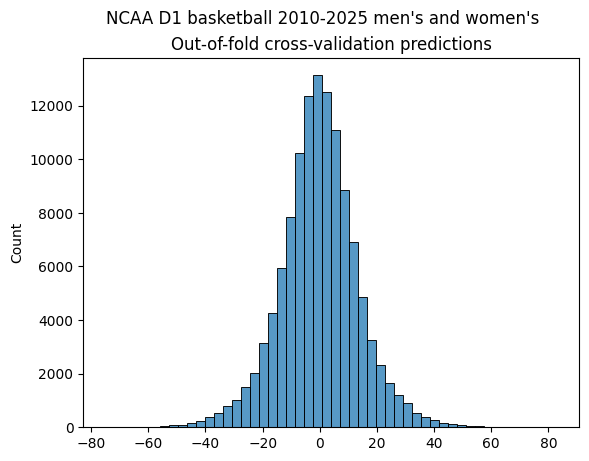

In [12]:
suptitle = "NCAA D1 basketball 2010-2025 men's and women's"
title = "Out-of-fold cross-validation predictions"

if is_notebook:
    sns.histplot(y_pred_oof, bins=50)
    plt.suptitle(suptitle)
    plt.title(title)

else:
    print()
    print(suptitle)
    print(title)
    hist, edges = np.histogram(y_pred_oof, bins=50)
    width = 80
    print(asciichartpy.plot(hist, {"height": 10, "width": width}))
    w50 = (width - 11) // 2
    w66 = (width - 11) * 2 // 3 - w50
    print(
        f"{floor(edges[len(edges)//2-1]):>{w50}}"
        f"{floor(edges[len(edges)*2//3]):>{w66}}"
    )
    print()

In [13]:
y_pred_prob = 1 / (1 + np.exp(-y_pred_oof * 0.25))
y_true = (train["Spread_1"] > 0).astype(int)
brier_score = np.mean((y_pred_prob - y_true) ** 2)
print(f"Brier score: {brier_score:.4f}")

Brier score: 0.1479


claude.ai:

> A Brier score of 0.1479 represents the mean squared error between your predicted win probabilities and the actual outcomes. Let me help you interpret this result:
> 
> #### Understanding the Brier Score
> 
> The Brier score ranges from 0 to 1, where:
> 
> - 0 is perfect prediction (you predicted exactly the right probability for every game)
> - 0.25 represents the score you'd get by always predicting 50% probability (random guessing)
> - 1 is the worst possible score (you predicted with complete confidence the opposite of what happened)
> 
> Your score of 0.1479 is significantly better than random guessing (0.25), which indicates your model has meaningful predictive power.
> 
> #### Contextualizing Your Score
> 
> For NCAA basketball game predictions:
> - Professional betting markets and sophisticated models typically achieve Brier scores in the 0.12-0.16 range
> - Your score of 0.1479 falls within this competitive range
> - The best models in previous March Machine Learning Mania competitions have achieved scores around 0.12-0.13
> 
> #### What This Means
>
> Your model is capturing meaningful patterns in the data. The 0.1479 Brier score suggests that:
> - Your approach of using team season statistics to predict point spreads, then converting to win probabilities, is valid
> - The model has good discriminative power (distinguishing between likely wins and losses)
> - The probability calibration (using the sigmoid with scaling factor 0.25) is reasonably effective

Note: There is data leakage in my approach, which artificially increases the out-of-fold cross-validation scores over scores involving real data (future games.) Specifically, the data leakage is that for regular season games, the season stats in X (the features used to fit/train the model) include the game being predicted. I am accepting this trade-off because it is a simpler, more efficient approach that gets more rows in my train dataset (vs. only predicting hitorical tournament games.) I could remove the game being predicted from the season stats for each row in the train dataset, but that would take more work with potentially little benefit and could greatly increase run time.

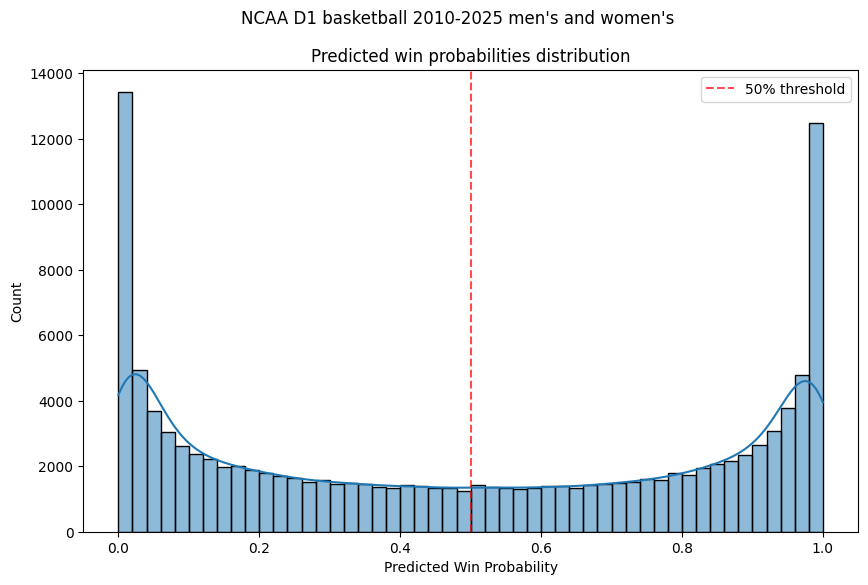

In [14]:
suptitle = "NCAA D1 basketball 2010-2025 men's and women's"
title = "Predicted win probabilities distribution"

if is_notebook:
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_prob, bins=50, kde=True)
    plt.axvline(0.5, color="red", linestyle="--", alpha=0.7, label="50% threshold")
    plt.xlabel("Predicted Win Probability")
    plt.ylabel("Count")
    plt.suptitle(suptitle)
    plt.title(title)
    plt.legend()
    plt.show()
else:
    print()
    print(suptitle)
    print(title)
    hist, _ = np.histogram(y_pred_prob, bins=50)
    print(asciichartpy.plot(hist, {"height": 10, "width": 80}))
    print()

claude.ai:

> The distribution actually reveals something important about your modeling approach. It's not centered around 0.5, and that's very interesting!
The bimodal (two-peaked) distribution you're seeing with high peaks near 0 and 1 tells us that your sigmoid transformation is creating very confident predictions. The scaling factor of 0.25 in your sigmoid function is making the transformation quite steep, which pushes many probabilities toward the extremes.
This pattern indicates:
> 
> Your model is making strong, polarized predictions rather than cautious ones hovering around 0.5.
The point spread predictions from your model are being transformed in a way that expresses high confidence - most games are predicted as either strong wins or strong losses.
Since your Brier score is 0.1479 (which is quite good), many of these confident predictions are actually correct! If they weren't, your Brier score would be much worse.
> 
> The distribution doesn't need to be centered at 0.5. In fact, if your model has good discriminative power, and games truly do have clear favorites and underdogs, you would expect to see more predictions at the extremes than in the middle.